# Adaptado de:
https://github.com/Project-MONAI/MONAI/blob/master/examples/notebooks/mednist_tutorial.ipynb.
# Classificação de imagens com o dataset MedNIST

Exemplo de treino e avaliação de ponta a ponta com base no conjunto de dados MedNIST.
Passaremos pelos seguintes passos:

- Criar um conjunto de dados MONAI para treino e teste
- Usar transformações MONAI para pré-processar dados
- Usar o DenseNet do MONAI para a tarefa de classificação
- Treinar o modelo com um programa PyTorch
- Avaliar no conjunto de dados de teste

### 1.1. Obter o conjunto de dados
O conjunto de dados do MedNIST foi recolhido de vários conjuntos do [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions), [o RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4) e [o conjunto de dados de raios-X do tórax do NIH](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

O conjunto de dados foi disponibilizado por [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Departamento de Radiologia, Mayo Clinic) sob Creative Commons [CC BY-SA 4.0 licença](https://creativecommons.org/licenses/by-sa/4.0/).

In [15]:
import os
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset, DataLoader

from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.networks.nets import densenet121
from monai.metrics import compute_roc_auc
from monai.utils import set_determinism
from monai.config import print_config

from torchinfo import summary
from livelossplot import PlotLosses

np.random.seed(0)
set_determinism(seed=0)
print_config()

MONAI version: 0.4.0
Numpy version: 1.19.1
Pytorch version: 1.7.1+cu101
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.1.0
scikit-image version: 0.17.2
Pillow version: 7.2.0
Tensorboard version: 2.2.1
gdown version: 3.12.2
TorchVision version: 0.8.2+cu101
ITK version: 5.1.0
tqdm version: 4.48.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.7.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
#Constantes
DATA_DIR= '../../../../../../datasets/MedNIST/'

BATCH_SIZE = 300

In [ ]:
#device management 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

## 1.2. Ler nomes de arquivos de imagem das pastas do conjunto de dados
Antes de tudo, verificar os arquivos do conjunto de dados e mostrar algumas estatísticas.
Existem 6 pastas no conjunto de dados: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT, que devem ser usados como rótulos para treinar nosso modelo de classificação.

In [5]:
def file_list(dir_path):
    class_names = sorted([x for x in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, x))])
    num_class = len(class_names)
    image_files = [[os.path.join(dir_path, class_name, x) 
                    for x in os.listdir(os.path.join(dir_path, class_name))] 
                   for class_name in class_names] #constroi uma lista de listas de ficheiros por diretoria de classe
    image_file_list = list()
    image_label_list = list()
    for i, class_name in enumerate(class_names): #para juntar as listas e construir a listaa com os labels em numerico
        image_file_list.extend(image_files[i])
        image_label_list.extend([i] * len(image_files[i]))
    return image_file_list, image_label_list, class_names

image_file_list, image_label_list, class_names = file_list(DATA_DIR)
print('Total image count:', len(image_label_list))
image_width, image_height = Image.open(image_file_list[0]).size
print("Image dimensions:", image_width, "x", image_height)
labels_cout= [image_label_list.count(x) for x in set(image_label_list)]
for i,label in enumerate(class_names):
    print(f"Label: {label:11}  {labels_cout[i]:5d} cases")

Total image count: 58954
Image dimensions: 64 x 64
Label: AbdomenCT    10000 cases
Label: BreastMRI     8954 cases
Label: CXR          10000 cases
Label: ChestCT      10000 cases
Label: Hand         10000 cases
Label: HeadCT       10000 cases


## 1.3. Visualizar alguns exemplos escolhidos aleatoriamente do conjunto de dados

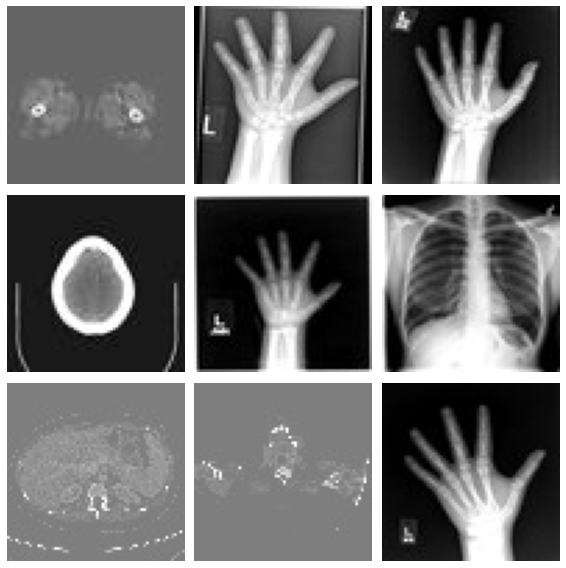

In [6]:
def visualize_sample_images(image_file_list,image_label_list,class_names):
    plt.subplots(3, 3, figsize=(8, 8))
    for i,k in enumerate(np.random.randint(len(image_label_list), size=9)):
        im = Image.open(image_file_list[k])
        arr = np.array(im)
        plt.subplot(3, 3, i + 1)
        plt.axis('off')
        plt.grid(b=None)
        plt.xlabel(class_names[image_label_list[k]])
        plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
    plt.tight_layout()
    plt.show()
    
visualize_sample_images(image_file_list,image_label_list,class_names)

## 1.4. Preparar listas de dados de treino, validação e teste
Selecionar aleatoriamente 10% do conjunto de dados como validação e 10% como teste

In [7]:
#separar a lista de ficheiros em 3 partes para treino, validação e teste
def holdout_dataset(image_file_list,image_label_list):
    valid_frac, test_frac = 0.1, 0.1
    trainX, trainY = list(), list()
    valX, valY = list(), list()
    testX, testY = list(), list()
    for i in range(len(image_label_list)):
        rann = np.random.random()
        if rann < valid_frac:
            valX.append(image_file_list[i])
            valY.append(image_label_list[i])
        elif rann < test_frac + valid_frac:
            testX.append(image_file_list[i])
            testY.append(image_label_list[i])
        else:
            trainX.append(image_file_list[i])
            trainY.append(image_label_list[i])
    return trainX, trainY, valX, valY, testX, testY

trainX, trainY, valX, valY, testX, testY = holdout_dataset(image_file_list,image_label_list)

print("Training count =",len(trainX))
print("Validation count =", len(valX))
print("Test count =",len(testX))

Training count = 47156
Validation count = 5913
Test count = 5885


-----------------------------------casos_treino-----------------------------------
casos: 47156
['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
['0', '1', '2', '3', '4', '5']
[8039 7116 8045 8008 7951 7997]
47156


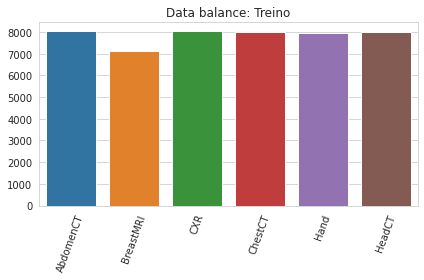

-----------------------------------casos_validação-----------------------------------
casos: 5913
['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
['0', '1', '2', '3', '4', '5']
[ 992  894  982 1033  994 1018]
5913


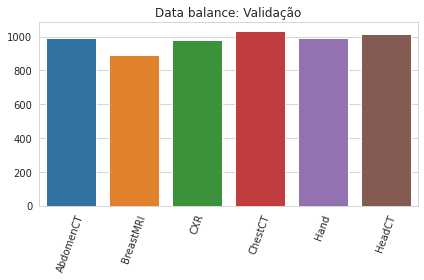

-----------------------------------casos_teste-----------------------------------
casos: 5885
['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
['0', '1', '2', '3', '4', '5']
[ 969  944  973  959 1055  985]
5885


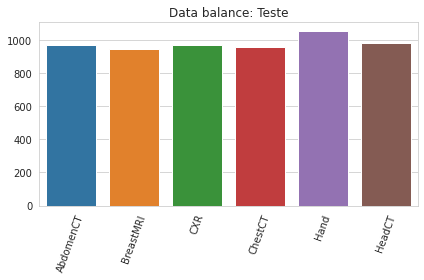

In [8]:
#verificar o balanceamento dos dados
def visualize_holdout_balance(labels, class_names, titulo):                          
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    x, y = np.unique(labels, return_counts=True)
    x_ext=[class_names[n]  for n in x]
    print(x_ext)
    print([str(n) for n in x])
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x_ext, y)
    grafico.set_title(f'Data balance: {titulo}')
    plt.xticks(rotation=70)
    plt.tight_layout()
    #plt.savefig('data_balance_MLP.png')
    plt.show()  
    
print("-----------------------------------casos_treino-----------------------------------")   
visualize_holdout_balance(trainY, class_names, 'Treino')
print("-----------------------------------casos_validação-----------------------------------")   
visualize_holdout_balance(valY, class_names, 'Validação')
print("-----------------------------------casos_teste-----------------------------------") 
visualize_holdout_balance(testY, class_names, 'Teste')

## 2.1. Definir transformações MONAI, Dataset e Dataloader para pré-processar dados

In [9]:
train_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True), #RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True), #RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ToTensor()
])

val_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

In [10]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=2)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## 2.2 Definir rede e otimizador
1. Definir a taxa de aprendizagem de quanto o modelo é atualizado por lote
2. Definir o número total da época, pois temos transformações misturadas e aleatórias, para que os dados de treino de cada época sejam diferentes
E como este é apenas um tutorial de introdução, vamos treinar 4 épocas.
Se treinar 10 épocas, o modelo pode atingir 100% de precisão no conjunto de dados de teste.
3. Usar o DenseNet do MONAI e mudar para o dispositivo GPU. Este DenseNet pode suportar tarefas de classificação 2D e 3D
4. Usar o otimizador Adam

In [11]:
model = densenet121(
                    spatial_dims=2,
                    in_channels=1,
                    out_channels=len(class_names)
                   ).to(device)


In [12]:
#print(model)
img=Image.open(trainX[0])
print(np.array(img).shape) #apenas um canal
print(summary(model, input_size=(BATCH_SIZE, 1,64,64), verbose=0))

(64, 64)
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [300, 1024, 2, 2]         --
|    └─Conv2d: 2-1                       [300, 64, 32, 32]         3,136
|    └─BatchNorm2d: 2-2                  [300, 64, 32, 32]         128
|    └─ReLU: 2-3                         [300, 64, 32, 32]         --
|    └─MaxPool2d: 2-4                    [300, 64, 16, 16]         --
|    └─_DenseBlock: 2-5                  [300, 256, 16, 16]        --
|    |    └─_DenseLayer: 3-1             [300, 96, 16, 16]         45,440
|    |    └─_DenseLayer: 3-2             [300, 128, 16, 16]        49,600
|    |    └─_DenseLayer: 3-3             [300, 160, 16, 16]        53,760
|    |    └─_DenseLayer: 3-4             [300, 192, 16, 16]        57,920
|    |    └─_DenseLayer: 3-5             [300, 224, 16, 16]        62,080
|    |    └─_DenseLayer: 3-6             [300, 256, 16, 16]        66,240
|    └─_Transition: 2-6                  [300, 1

## 3. Treino do modelo
Executar um treino típico do PyTorch que executa o loop de época e o loop de etapa, e fazer a validação após cada época.
Guardar os pesos do modelo no arquivo se obtiver a melhor precisão de validação.

In [35]:
def train_model(h5_file, train_dl, val_dl, model, loss_function, optimizer, epochs):
    liveloss = PlotLosses()
    best_metric = -1
    best_metric_epoch = -1
    metric_values = list()
    
    for epoch in range(epochs):
        logs = {}
        model.train()
        epoch_loss = 0
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) #Get predictions from the maximum value
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
        #Validation phase
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_images, val_labels in val_dl:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
                outputs = model(val_images)
                loss = loss_function(outputs, val_labels)
                running_loss += loss.detach() * val_images.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == val_labels.data)
                y_pred = torch.cat([y_pred, outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            epoch_loss = running_loss / len(val_dl.dataset)
            epoch_acc = running_corrects.float() / len(val_dl.dataset)
            logs['val_loss'] = epoch_loss.item()
            logs['val_accuracy'] = epoch_acc.item()
            auc_metric = compute_roc_auc(y_pred, y, to_onehot_y=True, softmax=True)
            metric_values.append(auc_metric)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print("current epoch:%d current AUC:%.4f current accuracy:%.4f best AUC:%.4f at epoch:%d"%(epoch+1,auc_metric,acc_metric,best_metric,best_metric_epoch))
        logs['val_AUC'] = auc_metric
        liveloss.update(logs)
        liveloss.send()
    print("train completed, best_metric:%.4f at epoch: %d"%(best_metric,best_metric_epoch))

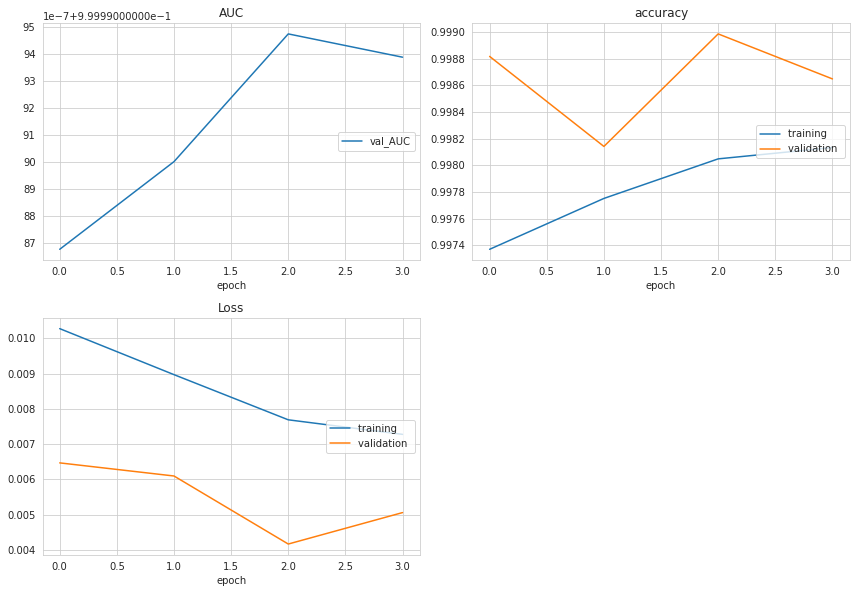

AUC
	val_AUC          	 (min:    1.000, max:    1.000, cur:    1.000)
accuracy
	training         	 (min:    0.987, max:    0.998, cur:    0.998)
	validation       	 (min:    0.992, max:    0.999, cur:    0.999)
Loss
	training         	 (min:    0.007, max:    0.061, cur:    0.007)
	validation       	 (min:    0.004, max:    0.061, cur:    0.005)
train completed, best_metric:1.0000 at epoch: 3
Tempo gasto: 1018.383189868182 segundos


In [36]:
#treino do modelo densenet121
EPOCHS = 4
LEARNING_RATE = 1e-5
loss_function = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE)
epoch_num = 4
val_interval = 1

starttime = time.perf_counter()
train_model('densenet121.pth', train_dl, val_dl, model, loss_function, optimizer, EPOCHS)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

## 4. Avaliar o modelo no conjunto de dados de teste
Após treino e validação, obtivemos o melhor modelo no teste de validação.
Precisamos avaliar o modelo no conjunto de dados de teste para verificar se ele é robusto e não está em overfitting.
Usaremos essas previsões para gerar um relatório de classificação.

5885
real:[2] previsão:[2]
real:[5] previsão:[5]
real:[4] previsão:[4]
real:[1] previsão:[1]
real:[2] previsão:[2]
real:[4] previsão:[4]
real:[5] previsão:[5]
real:[0] previsão:[0]
real:[5] previsão:[5]
real:[0] previsão:[0]
real:[0] previsão:[0]
Accuracy: 1.000

acertou:11 falhou:0
Accuracy: 1.000

acertou:11 falhou:0
              precision    recall  f1-score   support

   AbdomenCT     1.0000    0.9990    0.9995       969
   BreastMRI     1.0000    0.9989    0.9995       944
         CXR     1.0000    1.0000    1.0000       973
     ChestCT     0.9979    1.0000    0.9990       959
        Hand     1.0000    1.0000    1.0000      1055
      HeadCT     1.0000    1.0000    1.0000       985

    accuracy                         0.9997      5885
   macro avg     0.9997    0.9997    0.9997      5885
weighted avg     0.9997    0.9997    0.9997      5885

[[ 968    0    0    1    0    0]
 [   0  943    0    1    0    0]
 [   0    0  973    0    0    0]
 [   0    0    0  959    0    0]
 [  

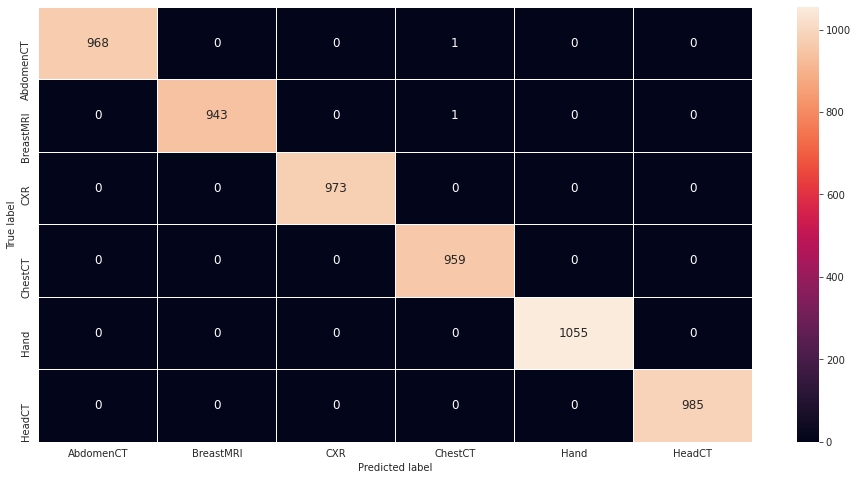

In [16]:
#Avaliar o modelo
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for inputs, labels in test_dl:
        # avaliar o modelo com os casos de teste
        inputs = inputs.to(device)
        labels = labels.to(device)
        yprev = model(inputs)
        # retirar o array numpy
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        # converter para a class dos labels
        yprev = np.argmax(yprev, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        # guardar
        predictions.append(yprev)
        actual_values.append(actual)
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions ):
    acertou=0
    falhou = 0
    primeiros=0
    i=0
    for r,p in zip(actual_values, predictions):
        if primeiros <20:
            print(f'real:{r} previsão:{p}') 
            primeiros +=1
        if r==p: acertou+=1  
        else: falhou+=1
        i+=1
        if i>10:
            break
    #calcular a accuracy
    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(test_dl.dataset)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    
#avaliar o modelo
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()

actual_values, predictions = evaluate_model(test_dl, model)

print(len(actual_values))
display_predictions(actual_values, predictions)
print(classification_report(actual_values, predictions, target_names=class_names, digits=4 ))
cr =classification_report(actual_values, predictions, target_names=class_names, output_dict=True)

list_classes=[n for n in list(cr.keys())[0:6] ] 
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

# Sensibilidade de oclusão
Um método para tentar visualizar por que a rede fez uma determinada previsão é a sensibilidade à oclusão. Ocluímos parte da imagem e vemos como a probabilidade de uma determinada previsão muda. Em seguida, iteramos sobre a imagem, movendo a parte obstruída à medida que avançamos e, ao fazê-lo, construímos um mapa de sensibilidade detalhando quais áreas foram as mais importantes na tomada de decisão.

In [21]:
def get_rand_im():
    test_ds = MedNISTDataset(testX, testY, val_transforms)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, num_workers=2, shuffle=True)
    itera = iter(test_loader)
    test_data = next(itera)  
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)

def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1,2, figsize=(13, 5))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.grid(b=None)
    plt.imshow(np.squeeze(im.cpu()), cmap='gray')
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.grid(b=None)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [22]:
#Get a random image and its corresponding label
im, label = get_rand_im()

Computing occlusion sensitivity: 100%|██████████| 4096/4096 [00:05<00:00, 724.36it/s]


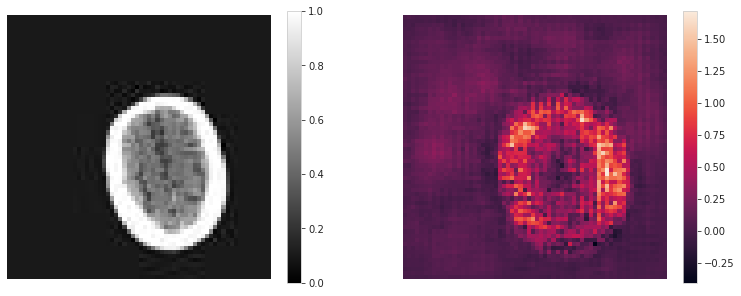

In [23]:
#Get the occlusion sensitivity map
from monai.metrics import occlusion_sensitivity

heatmap = occlusion_sensitivity.compute_occlusion_sensitivity(model, im, label, margin=2)
plot_occlusion_heatmap(im, heatmap)